In [1]:
import numpy as np
import ray
import matplotlib.pyplot as plt
import time
from utils import *
from procedures import *
plt.rcParams["font.sans-serif"] = "DejaVu Sans"
plt.rcParams["mathtext.default"]  = "it"
plt.rcParams["mathtext.fontset"]  = "dejavusans"

In [2]:
# rewrite the procedure to let it return the budget allocation

def EFG(generator, n0, ng, seed=0, expe_id=-1, **args):

    K = generator.syscount()
    ids = np.arange(K)
    
    np.random.seed(seed)

    counts = np.zeros(K)
    sample_means =  np.zeros(K)

    N = (n0+ng)*K

    used = n0*K
    
    for _id in ids:
        sample_means[_id] = np.mean(generator.get(_id, n0))
    counts = np.ones(K) * n0
    
    
    greedy_counts = np.zeros(K)
    while used < N:
        selected = np.argmax(sample_means)
        sample = generator.get(selected)
        sample_means[selected] = counts[selected] * sample_means[selected] + sample
        counts[selected] += 1
        greedy_counts[selected] += 1
        sample_means[selected]  = sample_means[selected] / counts[selected]
        used += 1
        
    estimated_bestid = np.nanargmax(sample_means)
    
    if expe_id >= 0:
        return expe_id, estimated_bestid, greedy_counts
    else:
        return estimated_bestid, greedy_counts


# remote version
@ray.remote
def remote_EFG(generator, n0, ng, seed=0, expe_id=-1, **args):

    K = generator.syscount()
    ids = np.arange(K)
    
    np.random.seed(seed)

    counts = np.zeros(K)
    sample_means =  np.zeros(K)

    N = (n0+ng)*K

    used = n0*K
    
    for _id in ids:
        sample_means[_id] = np.mean(generator.get(_id, n0))
    counts = np.ones(K) * n0
    
    greedy_counts = np.zeros(K)
    while used < N:
        selected = np.argmax(sample_means)
        sample = generator.get(selected)
        sample_means[selected] = counts[selected] * sample_means[selected] + sample
        counts[selected] += 1
        greedy_counts[selected] += 1
        sample_means[selected]  = sample_means[selected] / counts[selected]
        used += 1
        
    estimated_bestid = np.nanargmax(sample_means)
    
    if expe_id >= 0:
        return expe_id, estimated_bestid, greedy_counts
    else:
        return estimated_bestid, greedy_counts


In [3]:
# define problem configurations used in EC.3.5

class EMCVGenerator(object):
    def __init__(self, n_alternatives, gamma, lamda, var, best_index=0):
        self.n_alternatives = n_alternatives
        self.gamma = gamma
        self.means = -(np.arange(n_alternatives)-1)/n_alternatives*lamda
        self.means[best_index] = gamma
        self.best_mean = gamma
        self.variances = np.ones(self.n_alternatives)*var
        self.stds = np.sqrt(self.variances)
        
    def get(self, index, n=1):
        return np.random.normal(self.means[index], self.stds[index], n)
        
    def syscount(self):
        return self.n_alternatives
    
class EMCVFuncGenerator(object):
    def __init__(self, n_alternatives, gamma, func, var, best_index=0):
        self.n_alternatives = n_alternatives
        self.gamma = gamma
        self.means = -(np.arange(n_alternatives)-1)/n_alternatives*func(n_alternatives)
        self.means[best_index] = gamma
        self.best_mean = gamma
        self.variances = np.ones(self.n_alternatives)*var
        self.stds = np.sqrt(self.variances)
        
    def get(self, index, n=1):
        return np.random.normal(self.means[index], self.stds[index], n)
        
    def syscount(self):
        return self.n_alternatives


def func1(n):
    return np.sqrt(n)

def func2(n):
    return 0.1*n

In [7]:
num_cpus=96
ray.shutdown()
ray.init(num_cpus=num_cpus, ignore_reinit_error=True)

In [4]:
def evaluate_allocation(generators, return_results):
    size = len(return_results)
    budget_allocations = []
    for i in range(size):
        counts = return_results[i][2]
        budget_allocations.append(counts)
    return np.array(budget_allocations)

In [5]:
# rewrite the experiment function to analyze the budget allocation

def parallel_experiments(rng,  generators, policy=None, remote_policy=None, 
                         delta=0.01, test_time=False, args={}):
    _start = time.time()
    results = []
    n_replications = len(generators)
    k = generators[0].syscount()
    print("--------New experiments with  k={}----------------------".format(k))
    for expe_id in range(n_replications):
        _seed = rng.integers(1, 10e8)
        if test_time:
            if expe_id == 0:
                start = time.time()
                policy(generators[expe_id],  **args)
                end = time.time()
                print("Single replication takes: {}s".format(end-start))
                print("Estimated serial total time: {}s".format((end-start)* n_replications))
        else:
            pass
        results.append(remote_policy.remote(generators[expe_id], seed=_seed, expe_id = expe_id, **args))
    print("Start to simulate... at {}".format(time.ctime()))
    results = ray.get(results)
    PCS, PGS = evaluate_PCS(generators, results), evaluate_PGS(generators, results, delta=delta)
    budget_allocations = evaluate_allocation(generators, results)
    print("PCS:{}, PGS:{}".format(PCS, PGS))
    _end = time.time()
    print("Total time used: {}s, simulation ends at {}".format(_end-_start, time.ctime()))
    return PCS, PGS, budget_allocations

In [6]:
n_replications = 1000
 
min_power = 3
max_power = 16
base = 2

gamma = 0.1
var = 1

n0 = 80
ng = 20

In [9]:
results = []

seed = 20230805
np.random.seed(seed)
rng = np.random.default_rng(seed)

for lamda in [0, 2]:
    for power in np.arange(min_power, max_power+1):
        k = base ** power
        generators =  [EMCVGenerator(k, gamma, lamda, var) for i in range(n_replications)]
        PCS, PGS, allocations = parallel_experiments(rng, generators, policy=EFG, 
                                                     remote_policy=remote_EFG, args={"n0":n0, "ng":ng})

        average_number_allocated_alternatives = np.mean(np.sum(allocations[:, 1:] > 0, axis=1))
        rate_allocated_alternatives = average_number_allocated_alternatives/(k-1)

        allocated_to_best = allocations[:, 0]
        average_to_best2 = np.mean(allocated_to_best)/k

        _non_best_allocations = allocations[:, 1:]
        average_to_each_nonbest2 = np.nanmean([np.mean(row[np.nonzero(row)]) for row in _non_best_allocations if np.sum(row) > 0 ])

        non_best_means = generators[0].means[1:]
        average_mean_is_allocated = np.mean([np.mean(non_best_means[np.nonzero(row)]) for row in _non_best_allocations  if np.sum(row) > 0 ])
        average_lb_mean_is_allocated = np.mean([np.min(non_best_means[np.nonzero(row)]) for row in _non_best_allocations if np.sum(row) > 0])


        _result = [average_number_allocated_alternatives,
                  rate_allocated_alternatives,
                  average_to_best2,
                  average_to_each_nonbest2,
                  average_mean_is_allocated,
                  average_lb_mean_is_allocated]

        results.append(_result)
        
for func in [func1, func2]:
    for power in np.arange(min_power, max_power+1):
        print("This problem has {} alternatives".format(base**power))
        k = base**power
        generators =   [EMCVFuncGenerator(k, gamma, func, var) for i in range(n_replications)]
        PCS, PGS, allocations = parallel_experiments(rng, generators, policy=EFG, 
                                                     remote_policy=remote_EFG, args={"n0":n0, "ng":ng})

        average_number_allocated_alternatives = np.mean(np.sum(allocations[:, 1:] > 0, axis=1))
        rate_allocated_alternatives = average_number_allocated_alternatives/(k-1)

        allocated_to_best = allocations[:, 0]
        average_to_best2 = np.mean(allocated_to_best)/k

        _non_best_allocations = allocations[:, 1:]
        average_to_each_nonbest2 = np.nanmean([np.mean(row[np.nonzero(row)]) for row in _non_best_allocations if np.sum(row) > 0 ])

        non_best_means = generators[0].means[1:]
        average_mean_is_allocated = np.mean([np.mean(non_best_means[np.nonzero(row)]) for row in _non_best_allocations  if np.sum(row) > 0 ])
        average_lb_mean_is_allocated = np.mean([np.min(non_best_means[np.nonzero(row)]) for row in _non_best_allocations if np.sum(row) > 0])

        _result = [average_number_allocated_alternatives,
                  rate_allocated_alternatives,
                  average_to_best2,
                  average_to_each_nonbest2,
                  average_mean_is_allocated,
                  average_lb_mean_is_allocated]

        results.append(_result)

--------New experiments with  k=8----------------------
Start to simulate... at Sat Aug  5 21:34:52 2023
PCS:0.43, PGS:0.43
Total time used: 1.624204158782959s, simulation ends at Sat Aug  5 21:34:52 2023
--------New experiments with  k=16----------------------
Start to simulate... at Sat Aug  5 21:34:54 2023
PCS:0.31, PGS:0.31
Total time used: 1.4959101676940918s, simulation ends at Sat Aug  5 21:34:54 2023
--------New experiments with  k=32----------------------
Start to simulate... at Sat Aug  5 21:34:55 2023
PCS:0.293, PGS:0.293
Total time used: 1.5292439460754395s, simulation ends at Sat Aug  5 21:34:56 2023
--------New experiments with  k=64----------------------
Start to simulate... at Sat Aug  5 21:34:57 2023
PCS:0.238, PGS:0.238
Total time used: 1.594782829284668s, simulation ends at Sat Aug  5 21:34:57 2023
--------New experiments with  k=128----------------------
Start to simulate... at Sat Aug  5 21:34:59 2023
PCS:0.186, PGS:0.186
Total time used: 1.6045050621032715s, simul

PCS:0.804, PGS:0.804
Total time used: 11.172067642211914s, simulation ends at Sat Aug  5 21:56:52 2023
This problem has 8192 alternatives
--------New experiments with  k=8192----------------------
Start to simulate... at Sat Aug  5 21:56:55 2023
PCS:0.808, PGS:0.808
Total time used: 23.239818334579468s, simulation ends at Sat Aug  5 21:57:16 2023
This problem has 16384 alternatives
--------New experiments with  k=16384----------------------
Start to simulate... at Sat Aug  5 21:57:19 2023
PCS:0.777, PGS:0.777
Total time used: 51.92769408226013s, simulation ends at Sat Aug  5 21:58:08 2023
This problem has 32768 alternatives
--------New experiments with  k=32768----------------------
Start to simulate... at Sat Aug  5 21:58:12 2023
PCS:0.755, PGS:0.755
Total time used: 126.36546039581299s, simulation ends at Sat Aug  5 22:00:15 2023
This problem has 65536 alternatives
--------New experiments with  k=65536----------------------
Start to simulate... at Sat Aug  5 22:00:21 2023
PCS:0.751, 

In [11]:
results = np.array(results)

In [12]:
n_allocated = np.array([results.reshape(4, max_power-min_power+1, 6)[i][:, 0] for i in range(4)])
ratios_allocated = np.array([results.reshape(4, max_power-min_power+1, 6)[i][:, 1] for i in range(4)])
c_to_best = np.array([results.reshape(4, max_power-min_power+1, 6)[i][:, 2] for i in range(4)])
each_to_non_best = np.array([results.reshape(4, max_power-min_power+1, 6)[i][:, 3] for i in range(4)])
mean_allocated = np.array([results.reshape(4, max_power-min_power+1, 6)[i][:, 4] for i in range(4)])
lb_mean_allocated = np.array([results.reshape(4, max_power-min_power+1, 6)[i][:, 5] for i in range(4)])

In [ ]:
ratios_allocated

In [ ]:
n_allocated

In [ ]:
c_to_best

In [ ]:
each_to_non_best

In [ ]:
mean_allocated

In [ ]:
lb_mean_allocated

In [7]:
# results drawn from the above experiments for producing the Figure EC7 and EC8

# ratios_allocated = np.array([np.array([0.27171429, 0.246     , 0.24422581, 0.23980952, 0.24233858,
#         0.24061176, 0.24301174, 0.24365298, 0.24500879, 0.24506716,
#         0.24536088, 0.24428603, 0.24496594, 0.24459318]),
#  np.array([0.06042857, 0.03653333, 0.02606452, 0.02274603, 0.01954331,
#         0.0186    , 0.01788258, 0.01728348, 0.01705276, 0.01636093,
#         0.016225  , 0.01621724, 0.01552062, 0.01591249]),
#  np.array([0.05785714, 0.0302    , 0.01445161, 0.00904762, 0.00558268,
#         0.00348235, 0.00213699, 0.00139589, 0.00099951, 0.0006547 ,
#         0.00045196, 0.0002964 , 0.00020341, 0.0001393 ]),
#  np.array([8.28571429e-02, 4.04000000e-02, 2.09677419e-02, 1.02222222e-02,
#         5.40157480e-03, 2.63529412e-03, 1.25244618e-03, 6.36363636e-04,
#         3.27796776e-04, 1.59218559e-04, 7.66695153e-05, 3.73557956e-05,
#         2.00201422e-05, 9.78103304e-06])])

# n_allocated = np.array([np.array([1.9020000e+00, 3.6900000e+00, 7.5710000e+00, 1.5108000e+01,
#         3.0777000e+01, 6.1356000e+01, 1.2417900e+02, 2.4925700e+02,
#         5.0153300e+02, 1.0035500e+03, 2.0097510e+03, 4.0021380e+03,
#         8.0267990e+03, 1.6029414e+04]),
#  np.array([4.230000e-01, 5.480000e-01, 8.080000e-01, 1.433000e+00,
#         2.482000e+00, 4.743000e+00, 9.138000e+00, 1.768100e+01,
#         3.490700e+01, 6.699800e+01, 1.328990e+02, 2.656870e+02,
#         5.085640e+02, 1.042825e+03]),
#  np.array([0.405, 0.453, 0.448, 0.57 , 0.709, 0.888, 1.092, 1.428, 2.046,
#         2.681, 3.702, 4.856, 6.665, 9.129]),
#  np.array([0.58 , 0.606, 0.65 , 0.644, 0.686, 0.672, 0.64 , 0.651, 0.671,
#         0.652, 0.628, 0.612, 0.656, 0.641])]
# )

# each_to_non_best = np.array([np.array([59.28710363, 70.2901303 , 68.98043015, 72.82799837, 74.25298192,
#         74.9596784 , 75.89385722, 76.67157697, 76.69327012, 76.70844055,
#         77.08022388, 76.68126491, 76.92483222, 76.7566495 ]),
#  np.array([ 83.95289855, 136.85502755, 175.48618383, 203.27736185,
#         242.57895767, 240.10630709, 272.43089374, 293.63989582,
#         324.09826242, 319.19517832, 340.19361947, 363.58541814,
#         331.19107586, 361.49348417]),
#  np.array([   95.86848635,   154.19659091,   280.72382094,   393.4961964 ,
#           614.35966487,   873.48574197,  1428.09039801,  2044.49635588,
#          3295.91425355,  4657.88465578,  6321.00705473, 10569.6088637 ,
#         15808.83646401, 23664.91060807]),
#  np.array([7.47534014e+01, 1.30841230e+02, 2.16152751e+02, 3.79247573e+02,
#         6.51119915e+02, 1.15121648e+03, 2.51169889e+03, 4.31473716e+03,
#         9.75731347e+03, 1.36980496e+04, 3.18253160e+04, 7.41431448e+04,
#         1.32142400e+05, 2.73665636e+05])]
# )

# c_to_best = np.array([np.array([7.674875  , 5.4406875 , 4.3260625 , 3.12314063, 2.25099219,
#         1.984125  , 1.5230332 , 1.26829199, 1.1428667 , 1.10807764,
#         1.00059033, 1.16814526, 1.05950305, 1.12503181]),
#  np.array([15.59      , 15.47575   , 15.70990625, 15.02526562, 14.60503906,
#         14.0486875 , 13.37218359, 12.91960645, 12.45976855, 12.7625415 ,
#         12.38063477, 11.96645898, 12.79966867, 12.16331125]),
#  np.array([15.157125  , 15.6551875 , 16.14325   , 16.62103125, 16.55542188,
#         16.97229297, 16.98003516, 16.72862402, 15.96162744, 15.98616846,
#         16.09219604, 15.49837207, 15.0760365 , 15.00183086]),
#  np.array([14.847125  , 15.247875  , 15.74271875, 16.2430625 , 16.58700781,
#         17.00131641, 16.87000391, 17.28823047, 16.88062744, 17.75768115,
#         17.46435913, 17.31345691, 17.3377699 , 17.33814058])]
# )

# lb_mean_allocated = np.array([np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
#  np.array([-0.00905797, -0.03383264, -0.06489965, -0.08434993, -0.10196128,
#         -0.12776117, -0.15710106, -0.18477148, -0.21441602, -0.23728125,
#         -0.26358423, -0.28583899, -0.30628473, -0.32806348]),
#  np.array([-0.00175461, -0.01136364, -0.0237398 , -0.03630705, -0.04728856,
#         -0.06229236, -0.07024895, -0.08433684, -0.09684266, -0.10659762,
#         -0.11973904, -0.1283354 , -0.14251279, -0.1574658 ]),
#  np.array([-0.04265306, -0.04475806, -0.04497154, -0.04951456, -0.04808743,
#         -0.04755639, -0.04921875, -0.04492481, -0.04878957, -0.05037879,
#         -0.05078431, -0.04254902, -0.04228675, -0.04519231])])

In [8]:
labels = ["$\lambda=0$", "$\lambda=2$", "$\lambda=\\sqrt{k}$", "$\lambda=0.1k$"]
labels = ["Slippage", "Bounded means", "","Progressively worse means"]

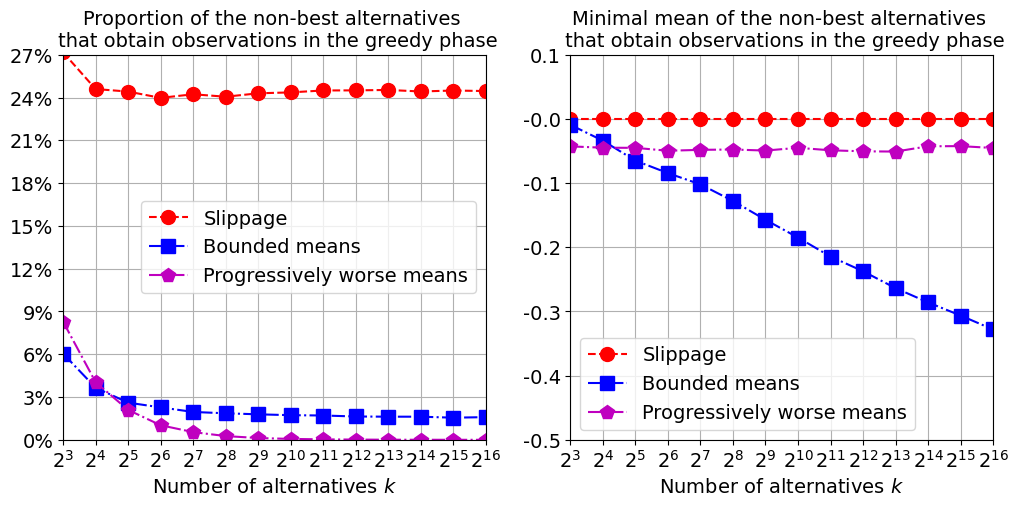

In [9]:
fontsize = 14
powers = np.arange(min_power, max_power+1)

colors = ["r" ,"b", "c", "m", "g", "c"]
markers = ["o", "s", "d", "p", "*", "D", "p"]
line_styles = ["--", "-.", ":", "-.", "--"]


fig = plt.figure(figsize= (12, 5))


fig_plots = [(1,2,1), (1,2, 2)]
"(Log)The number of non-best alternatives \n that obtain observations in the greedy phase"
titles = ["Proportion of the non-best alternatives \n that obtain observations in the greedy phase",
         "Minimal mean of the non-best alternatives \n that obtain observations in the greedy phase"]
powers = np.arange(min_power, max_power+1)


for i, fig_plot in enumerate(fig_plots):
    
    if i == 1:
        ax = fig.add_subplot(*fig_plots[i])

        results = lb_mean_allocated

        for j, result in enumerate(results):
            if j != 2:
                plt.plot(powers, result, line_styles[j], marker=markers[j], markersize=10,  color=colors[j], label=labels[j])
                

        plt.xlim(min_power, max_power)
        xticks = np.arange(min_power, max_power+1)
        xticklabels = ["2^{"+str(power)+"}" for power in xticks]
        xticklabels = ["$"+power_label+"$" for power_label in xticklabels]
        plt.xticks(powers, xticklabels,fontsize=fontsize)

        plt.ylim(-0.5, 0.1)
        yticks = np.arange(-0.5, 0.2, 0.1)
        yticklabels = ["%.1f"%(tick) for tick in yticks]
        plt.yticks(yticks, yticklabels, fontsize=fontsize)

        ax.legend(prop={"size":fontsize}, ncol=1, markerscale=1.0)
        ax.set_xlabel("Number of alternatives $k$", size=fontsize)
        plt.title(titles[i], fontsize=fontsize)
        plt.grid(0.2)
        
    if i == 0:
        ax = fig.add_subplot(*fig_plots[i])
        
        results = ratios_allocated
        
        for j, result in enumerate(results):
            if j != 2:
                plt.plot(powers, result, line_styles[j], marker=markers[j], markersize=10,  color=colors[j], label=labels[j])

        plt.xlim(min_power, max_power)
        xticks = np.arange(min_power, max_power+1)
        xticklabels = ["2^{"+str(power)+"}" for power in xticks]
        xticklabels = ["$"+power_label+"$" for power_label in xticklabels]
        plt.xticks(powers, xticklabels,fontsize=fontsize)

        plt.ylim(0, 0.27)
        yticks = np.arange(0, 0.3, 0.03)
        yticklabels = ["%.0f"%(tick*100)+"%" for tick in yticks]
        plt.yticks(yticks, yticklabels, fontsize=fontsize)

        ax.legend(prop={"size":fontsize}, ncol=1, markerscale=1.0)
        ax.set_xlabel("Number of alternatives $k$", size=fontsize)
        plt.title(titles[i], fontsize=fontsize)
        plt.grid(0.2)
        
plt.savefig("Figure_EC7.pdf", bbox_inches ="tight")
plt.show()

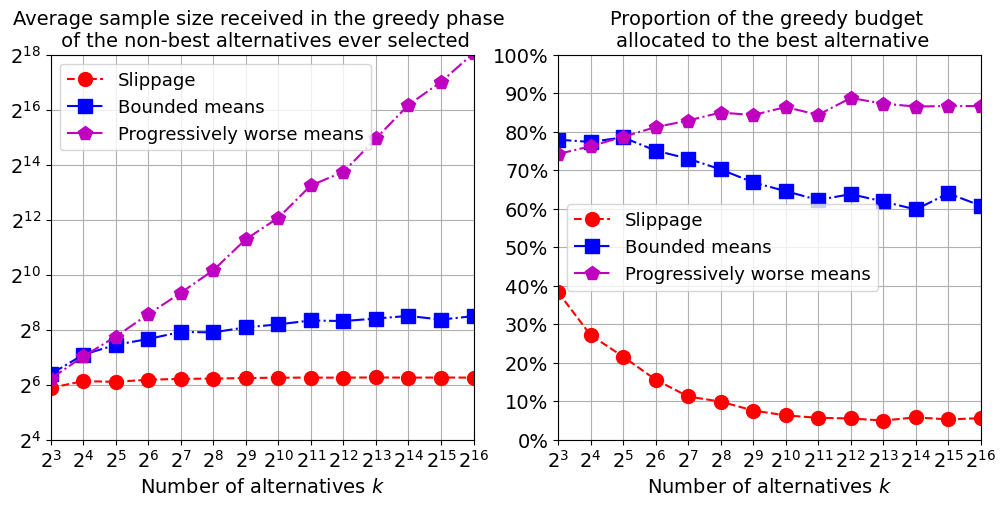

In [10]:
fontsize = 14
powers = np.arange(min_power, max_power+1)

colors = ["r" ,"b", "c", "m", "g", "c"]
markers = ["o", "s", "d", "p", "*", "D", "p"]
line_styles = ["--", "-.", ":", "-.", "--"]


fig = plt.figure(figsize= (12, 5))


fig_plots = [(1,2,1), (1,2, 2)]

titles = ["Average sample size received in the greedy phase \n of the non-best alternatives ever selected", 
          "Proportion of the greedy budget \n allocated to the best alternative"]
powers = np.arange(min_power, max_power+1)


for i, fig_plot in enumerate(fig_plots):
    
    if i == 0:
        ax = fig.add_subplot(*fig_plots[i])

        results = each_to_non_best

        for j, result in enumerate(results):
            if j != 2:
                plt.plot(powers, result, line_styles[j], marker=markers[j], markersize=10,  color=colors[j], label=labels[j])

        plt.xlim(min_power, max_power)
        xticks = np.arange(min_power, max_power+1)
        xticklabels = ["2^{"+str(power)+"}" for power in xticks]
        xticklabels = ["$"+power_label+"$" for power_label in xticklabels]
        plt.xticks(powers, xticklabels,fontsize=fontsize)

        plt.ylim(16, 2**18)
        ax.set_yscale("log", base=2)
        ax.tick_params(axis='y', labelsize=fontsize)
    
        ax.legend(prop={"size":fontsize-1}, ncol=1, markerscale=1.0)
        ax.set_xlabel("Number of alternatives $k$", size=fontsize)
        plt.title(titles[i], fontsize=fontsize)
        plt.grid(0.2)
        
    if i == 1:
        ax = fig.add_subplot(*fig_plots[i])
        results = c_to_best/20

        for j, result in enumerate(results):
            if j != 2:
                plt.plot(powers, result, line_styles[j], marker=markers[j], markersize=10,  color=colors[j], label=labels[j])

        plt.xlim(min_power, max_power)
        xticks = np.arange(min_power, max_power+1)
        xticklabels = ["2^{"+str(power)+"}" for power in xticks]
        xticklabels = ["$"+power_label+"$" for power_label in xticklabels]
        plt.xticks(powers, xticklabels,fontsize=fontsize)

        plt.ylim(0, 1)
        yticks = np.arange(0, 1.1, 0.1)
        yticklabels = ["%.0f"%(tick*100)+"%" for tick in yticks]
        plt.yticks(yticks, yticklabels, fontsize=fontsize)

        ax.legend(prop={"size":fontsize-1}, ncol=1, markerscale=1.0)
        ax.set_xlabel("Number of alternatives $k$", size=fontsize)
        plt.title(titles[i], fontsize=fontsize)
        plt.grid(0.2)

plt.savefig("Figure_EC8.pdf", bbox_inches ="tight")
plt.show()